In [10]:

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForMaskedLM
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import logging
from tqdm.auto import tqdm
import os
import matplotlib.pyplot as plt
from typing import Dict, List
import json
import datetime
import warnings
# from google.colab import drive

CUDA_LAUNCH_BLOCKING=1

warnings.filterwarnings("ignore")
# drive.mount('/content/drive')

#### Classe EFCAMDATDataset

La classe EFCAMDATDataset est conçue pour faciliter la gestion et la préparation du corpus EFCAMDAT. Elle hérite de Dataset de PyTorch et permet de transformer des textes et leurs niveaux CEFR (Cadre Européen Commun de Référence pour les Langues) en un format exploitable pour l’entraînement de modèles BERT.

1.	Initialisation (__init__)
	-	Paramètres :
        -	texts : Liste contenant les phrases du corpus.
        -	cefr_levels : Liste des niveaux CEFR associés à chaque texte (ex : A1, B2).
        -	tokenizer : Tokenizer du modèle BERT pour convertir les textes en séquences de tokens.
        -	max_length : Longueur maximale autorisée pour chaque séquence (512 par défaut).
	-	Processus :
        -	Stocke les phrases et les niveaux CEFR fournis.
        -	Associe chaque niveau CEFR à une valeur numérique pour simplifier leur traitement. Par exemple : {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}. Les niveaux non reconnus sont automatiquement convertis en 0.
2.	Méthode __len__
      -	Retourne le nombre total de textes dans le corpus. Cela permet au DataLoader de connaître la taille du jeu de données.
3.	Méthode __getitem__
    -	Cette méthode récupère un exemple à un index donné, le prépare, puis renvoie un dictionnaire contenant :
        -	input_ids : Séquence de tokens masqués selon la stratégie de masked language modeling.
        -	attention_mask : Masque binaire indiquant les positions valides (1) et celles remplies par du padding (0).
        -	labels : Séquence d’origine des tokens (non masqués), utilisée comme référence pendant l’entraînement.
        -	level : Niveau CEFR de l’exemple sous forme numérique.
	  -	Stratégie de masquage :
        -	Conformément à l’article BERT, 15 % des tokens valides sont sélectionnés aléatoirement pour être masqués :
            -	80 % des tokens sélectionnés sont remplacés par le token [MASK].
            -	10 % sont remplacés par un token aléatoire.
            -	10 % sont laissés inchangés.
	      -	Détails du processus :
            -	Le texte est tokenisé avec truncation et padding pour s’assurer que toutes les séquences atteignent max_length.
            -	Les tokens sont ensuite modifiés selon les règles de masquage.
            -	Les input_ids originaux sont conservés dans les labels pour la supervision.

In [11]:
class EFCAMDATDataset(Dataset):
    """
    Classe pour le chargement et la préparation des données du corpus EFCAMDAT.
    Permet de transformer les textes et leurs niveaux CEFR en un format utilisable
    pour l'entraînement de modèles BERT avec du masquage de tokens.
    """

    def __init__(
        self,
        texts: List[str],
        cefr_levels: List[str],
        tokenizer: BertTokenizer,
        max_length: int = 512
    ):
        """
        Initialisation de la classe.

        Args:
            texts (List[str]): Liste des textes du corpus.
            cefr_levels (List[str]): Liste des niveaux CEFR (ex. "A1", "B2") pour chaque texte.
            tokenizer (BertTokenizer): Tokenizer BERT pour convertir le texte en tokens.
            max_length (int): Longueur maximale des séquences après tokenisation (par défaut 512).
        """
        self.texts = texts
        self.cefr_levels = cefr_levels
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Dictionnaire pour convertir les niveaux CEFR en valeurs numériques
        self.cefr_to_num = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}

        # Conversion des niveaux CEFR en valeurs numériques (0 pour les niveaux inconnus)
        self.numeric_levels = [self.cefr_to_num.get(level, 0) for level in cefr_levels]

    def __len__(self):
        """
        Retourne la taille du jeu de données (nombre total de textes).

        Returns:
            int: Nombre de textes dans le corpus.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Prépare les données pour une phrase donnée.

        Args:
            idx (int): Index de la phrase à récupérer.

        Returns:
            dict: Dictionnaire contenant les données préparées :
                - 'input_ids': Tenseur des tokens masqués.
                - 'attention_mask': Masque indiquant les positions valides.
                - 'labels': Tenseur des tokens originaux (non masqués).
                - 'level': Niveau CEFR de l'exemple (numérique).
        """
        # Récupère le texte et le niveau correspondant à l'index donné
        text = self.texts[idx]
        level = self.numeric_levels[idx]

        # Tokenise le texte et ajoute padding pour atteindre la longueur max
        encoding = self.tokenizer(
            text,
            truncation=True,  # Tronque le texte si sa longueur dépasse max_length
            max_length=self.max_length,  # Longueur maximale des séquences
            padding='max_length',  # Ajoute du padding si nécessaire
            return_tensors='pt'  # Retourne un tenseur PyTorch
        )

        # Extraire les tokens et le masque d'attention
        input_ids = encoding['input_ids'].squeeze()  # Tokens du texte (1D après squeeze)
        attention_mask = encoding['attention_mask'].squeeze()  # Masque d'attention (1 si valide, 0 sinon)

        # Crée une copie des input_ids pour appliquer le masquage
        masked_input_ids = input_ids.clone()

        # Identifie les positions valides pour le masquage (exclut le padding (token ajouté pour atteindre max_length))
        valid_positions = attention_mask.bool()

        # Calcule le nombre de tokens valides à masquer (15 % des tokens valides)
        n_tokens = valid_positions.sum().item()  # Nombre total de tokens valides (provenant du texte original)
        n_to_mask = max(1, round(0.15 * n_tokens))  # Au moins 1 token à masquer

        # Récupère les indices des positions valides
        valid_positions_idx = valid_positions.nonzero().squeeze()
        if valid_positions_idx.dim() == 0:  # Cas spécial : un seul token valide
            valid_positions_idx = valid_positions_idx.unsqueeze(0)

        # Sélectionne aléatoirement les positions à masquer
        positions_to_mask = valid_positions_idx[torch.randperm(len(valid_positions_idx))[:n_to_mask]]

        # Applique le masquage aux positions sélectionnées
        for position in positions_to_mask:
            prob = torch.rand(1).item()  # Génère une probabilité aléatoire
            if prob < 0.8:
                # 80 % des cas : remplacer par le token [MASK]
                masked_input_ids[position] = self.tokenizer.mask_token_id
            elif prob < 0.9:
                # 10 % des cas : remplacer par un token aléatoire
                masked_input_ids[position] = torch.randint(0, self.tokenizer.vocab_size, (1,))
            # 10 % des cas restants : ne rien changer au token

        # Retourne un dictionnaire contenant les données nécessaires
        return {
            'input_ids': masked_input_ids,  # Tokens masqués
            'attention_mask': attention_mask,  # Masque indiquant les positions valides
            'labels': input_ids,  # Tokens originaux pour la supervision
            'level': torch.tensor(level, dtype=torch.long)  # Niveau CEFR sous forme numérique
        }

In [12]:
class TrainingTracker:
    """Classe pour suivre et enregistrer les métriques d'entraînement."""

    def __init__(self, output_dir: str):
        """
        Initialisation de la classe.

        Args:
            output_dir (str): Répertoire où les graphiques et l'historique seront sauvegardés.
        """
        self.output_dir = output_dir
        self.history = {
            'train_loss': [],  # Loss d'entraînement
            'val_loss': [],  # Loss de validation
            'train_acc': [],  # Précision d'entraînement
            'val_acc': []  # Précision de validation
        }
        os.makedirs(output_dir, exist_ok=True)
        self.timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    def add_epoch_metrics(self, train_loss, val_loss, train_acc, val_acc):
        """
        Ajoute les métriques d'une époque (entraînement et validation).

        Args:
            train_loss (float): Perte moyenne sur le jeu d'entraînement.
            val_loss (float): Perte moyenne sur le jeu de validation.
            train_acc (float): Précision sur le jeu d'entraînement.
            val_acc (float): Précision sur le jeu de validation.
        """
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc'].append(train_acc)
        self.history['val_acc'].append(val_acc)

    def plot_metrics(self):
        """
        Affiche les courbes des métriques : précision et perte pour entraînement et validation.
        """
        epochs = range(1, len(self.history['train_acc']) + 1)

        # Courbe de précision
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.history['train_acc'], 'b', label='Training Accuracy')
        plt.plot(epochs, self.history['val_acc'], 'r', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Courbe de perte
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, self.history['train_loss'], 'b', label='Training Loss')
        plt.plot(epochs, self.history['val_loss'], 'r', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def save_history(self):
        """
        Sauvegarde l'historique des métriques au format JSON.
        """
        # Chemin du fichier JSON
        history_path = os.path.join(self.output_dir, f'training_history_{self.timestamp}.json')

        # Écriture de l'historique dans le fichier
        with open(history_path, 'w') as f:
            json.dump(self.history, f, indent=4)  # Indente pour rendre le fichier lisible


In [13]:
def get_device():
    """
    Fonction pour sélectionner le device (CPU, CUDA, MPS) disponible.
    """
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS device")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA device")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

In [14]:
def calculate_accuracy(predictions, labels):
    """Calculer l'accuracy pour un batch"""
    pred_tokens = predictions.argmax(dim=-1)
    correct = (pred_tokens == labels) & (labels != -100)  # Ignorer les tokens paddés
    return correct.float().mean().item()

## Entrainement

#### Fonction train_model
La fonction train_model permet d’entraîner un modèle BERT pour une tâche de masked language modeling sur un corpus donné (ici, EFCAMDAT). Elle intègre une phase de validation pour évaluer la performance du modèle après chaque époque.

Fonctionnalités principales :
- Paramètres :
    - df : Le DataFrame contenant les colonnes text (textes du corpus) et cefr (niveaux associés).
    - model_name : Nom du modèle BERT pré-entraîné à utiliser (par défaut, bert-base-uncased).
    - output_dir : Répertoire où seront sauvegardés le modèle, le tokenizer et les graphiques de suivi.
    - batch_size : Taille des lots utilisés pour l’entraînement et la validation.
    - epochs : Nombre d’époques (itérations complètes sur l’ensemble des données).
    - learning_rate : Taux d’apprentissage de l’optimiseur AdamW.
    - max_length : Longueur maximale des séquences après tokenisation.
    - val_split : Proportion des données réservée pour la validation (par défaut 10 %).

- Processus :
    1.	Préparation des données :
      - Les données sont divisées en deux ensembles : entraînement et validation à l’aide de train_test_split.
      -	Les données textuelles sont transformées en tokens grâce au tokenizer BERT.
	2.	Configuration du modèle :
      - Le modèle BERT est initialisé avec les poids pré-entraînés spécifiés dans model_name.
      - Il est déplacé sur l’appareil de calcul détecté (CPU ou GPU).
	3.	Entraînement :
      - Le modèle est entraîné sur les données d’entraînement en mode train().
      - Pour chaque lot (batch), le modèle :
      - Calcule la perte (loss) pour les tokens masqués.
      - Met à jour les poids par rétropropagation grâce à l’optimiseur AdamW.
      - Enregistre les métriques d’entraînement, notamment la précision.
	4.	Validation :
      - Après chaque époque, le modèle passe en mode eval() pour mesurer sa performance sur les données de validation.
      - La perte et la précision moyennes sont calculées sans mise à jour des poids.
	5.	Suivi des métriques :
      - Les métriques d’entraînement et de validation (perte et précision) sont enregistrées à l’aide de la classe TrainingTracker.
      - Des graphiques des courbes d’apprentissage sont générés et sauvegardés pour visualiser la progression du modèle.
	6.	Sauvegarde des résultats :
      - Le meilleur modèle (selon la perte de validation) est sauvegardé pour une réutilisation future.
      - L’historique des métriques est exporté en format JSON.

- Retour :
    - La fonction retourne le modèle et le tokenizer finaux entraînés.


In [15]:
def train_model(
    df: pd.DataFrame,
    model_name: str = 'bert-base-uncased',
    output_dir: str = 'bert-efcamdat',
    batch_size: int = 8,
    epochs: int = 3,
    learning_rate: float = 2e-5,
    max_length: int = 512,
    val_split: float = 0.1
):
    """
    Entraîne un modèle BERT pour le masked language modeling sur un corpus donné.

    Args:
        df (pd.DataFrame): Données contenant les colonnes 'text' et 'cefr'.
        model_name (str): Modèle BERT pré-entraîné à utiliser (par défaut : 'bert-base-uncased').
        output_dir (str): Répertoire pour sauvegarder le modèle, le tokenizer et les graphiques.
        batch_size (int): Taille des batchs.
        epochs (int): Nombre d'époques.
        learning_rate (float): Taux d'apprentissage pour l'optimiseur.
        max_length (int): Longueur maximale des séquences tokenisées.
        val_split (float): Fraction des données utilisée pour la validation.

    Returns:
        tuple: Le modèle et le tokenizer entraînés.
    """
    # Initialisation
    device = get_device()
    tracker = TrainingTracker(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    # Séparation des données
    train_df, val_df = train_test_split(df, test_size=val_split, random_state=42)
    tokenizer = BertTokenizer.from_pretrained(model_name, use_fast=True)
    model = BertForMaskedLM.from_pretrained(model_name).to(device)

    # Préparation des datasets et DataLoaders
    train_dataset = EFCAMDATDataset(train_df['text'].tolist(), train_df['cefr'].tolist(), tokenizer, max_length)
    val_dataset = EFCAMDATDataset(val_df['text'].tolist(), val_df['cefr'].tolist(), tokenizer, max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')

    # Boucle principale
    for epoch in range(epochs):
        # Entraînement
        model.train()
        train_loss, train_acc = 0, 0

        for batch in tqdm(train_loader, desc=f"Époque {epoch + 1}/{epochs} (Entraînement)"):
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            accuracy = calculate_accuracy(outputs.logits, labels)

            train_loss += loss.item()
            train_acc += accuracy

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validation
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Époque {epoch + 1}/{epochs} (Validation)"):
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

                val_loss += outputs.loss.item()
                val_acc += calculate_accuracy(outputs.logits, labels)

        # Moyennes des métriques
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = (train_acc / len(train_loader)) * 100
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = (val_acc / len(val_loader)) * 100

        # Mise à jour du tracker
        tracker.add_epoch_metrics(avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc)

        print(f"Époque {epoch + 1}:")
        print(f"  -> Perte Entraînement : {avg_train_loss:.4f}, Précision Entraînement : {avg_train_acc:.2f}%")
        print(f"  -> Perte Validation : {avg_val_loss:.4f}, Précision Validation : {avg_val_acc:.2f}%")

        # Sauvegarde du meilleur modèle
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model.save_pretrained(f"{output_dir}/best_model")
            tokenizer.save_pretrained(f"{output_dir}/best_model")

    # Génération des graphiques et sauvegarde de l'historique
    tracker.plot_metrics()
    tracker.save_history()

    return model, tokenizer

### N'entrainer que sur un échantillon car trop long

In [16]:
def sample_stratified_data(df: pd.DataFrame, sample_size: int = 5000) -> pd.DataFrame:
    """
    Échantillonne les données en conservant la distribution des niveaux CEFR
    uniquement pour les lignes avec le prompt 'Introducing yourself by email.'

    Args:
        df: DataFrame d'origine
        sample_size: Nombre total d'exemples souhaités

    Returns:
        DataFrame échantillonné
    """
    # Filtrer le DataFrame pour ne conserver que les lignes avec le prompt spécifique
    prompt_df = df[df['topic'] == 'Introducing yourself by email']
    print(f"Taille après filtrage : {len(prompt_df)}")
    
    # Vérifier la distribution des niveaux CEFR après filtrage
    print("\nDistribution des niveaux CEFR après filtrage :")
    print(prompt_df['cefr'].value_counts())

    # Calculer la distribution originale des niveaux CEFR sur les lignes filtrées
    cefr_distribution = prompt_df['cefr'].value_counts(normalize=True)

    # Initialiser le DataFrame final pour les données échantillonnées
    sampled_df = pd.DataFrame()

    # Échantillonner pour chaque niveau CEFR
    for cefr_level in cefr_distribution.index:
        n_samples = int(sample_size * cefr_distribution[cefr_level])
        level_data = prompt_df[prompt_df['cefr'] == cefr_level]

        if len(level_data) > n_samples:
            level_sampled = level_data.sample(n=n_samples, random_state=42)
        else:
            print(f"Pas assez d'exemples pour {cefr_level}. Disponible : {len(level_data)}")
            level_sampled = level_data

        sampled_df = pd.concat([sampled_df, level_sampled])

    # Mélanger le DataFrame final
    sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Échantillonnage terminé. Taille du DataFrame : {len(sampled_df)}")
    return sampled_df



Distribution originale des niveaux CEFR:
cefr
A1    191663
A2    129591
B1     61506
B2     18187
C1      5115
Name: count, dtype: int64

Nombre total de phrase: 406062
Taille après filtrage : 34282

Distribution des niveaux CEFR après filtrage :
cefr
A1    34282
Name: count, dtype: int64
Échantillonnage terminé. Taille du DataFrame : 5000

Distribution après échantillonnage:
cefr
A1    5000
Name: count, dtype: int64

Nombre de phrase après échantillonnage: 5000
Using CUDA device

PyTorch version: 2.5.1+cu121
Device: cuda
Using CUDA device


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Époque 1/3 (Validation): 100%|██████████| 63/63 [05:46<00:00,  5.50s/it]


Époque 1:
  -> Perte Entraînement : 0.8901, Précision Entraînement : 93.87%
  -> Perte Validation : 0.0303, Précision Validation : 99.46%


Époque 2/3 (Validation): 100%|██████████| 63/63 [05:04<00:00,  4.83s/it]


Époque 2:
  -> Perte Entraînement : 0.0289, Précision Entraînement : 99.48%
  -> Perte Validation : 0.0266, Précision Validation : 99.51%


Époque 3/3 (Validation): 100%|██████████| 63/63 [05:16<00:00,  5.02s/it]


Époque 3:
  -> Perte Entraînement : 0.0256, Précision Entraînement : 99.52%
  -> Perte Validation : 0.0240, Précision Validation : 99.52%


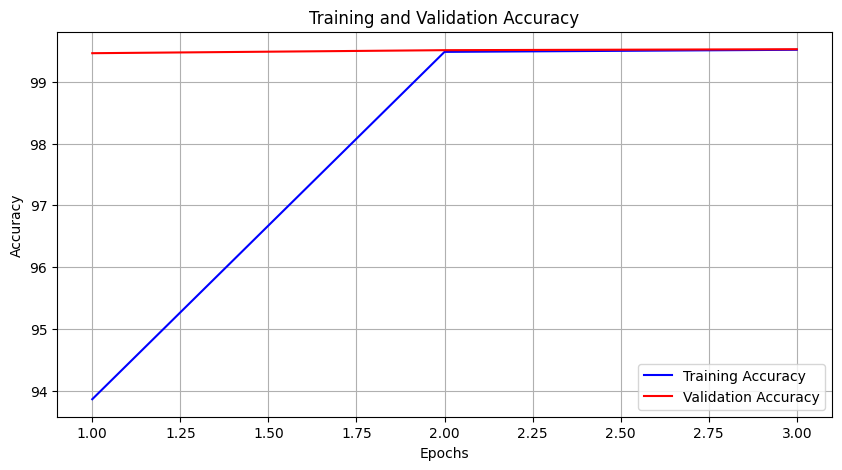

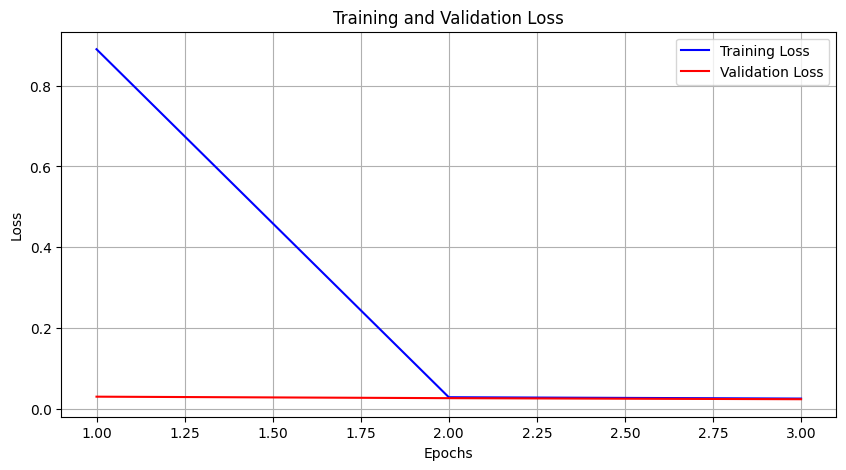

2024-12-19 23:41:29,133 - INFO - Training completed successfully.


In [23]:
 # Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

try:
    # Chargement des données
    excel_path = "Final database (main prompts).xlsx"
    df = pd.read_excel(excel_path)

    # Afficher la distribution originale
    print("\nDistribution originale des niveaux CEFR:")
    original_dist = df['cefr'].value_counts()
    print(original_dist)
    print("\nNombre total de phrase:", len(df))

    # Échantillonnage des données
    sample_size = 5000  # Nombre total de phrase après échantillonnage
    sampled_df = sample_stratified_data(df, sample_size)

    # Afficher la nouvelle distribution
    print("\nDistribution après échantillonnage:")
    sampled_dist = sampled_df['cefr'].value_counts()
    print(sampled_dist)
    print("\nNombre de phrase après échantillonnage:", len(sampled_df))

    # Affichage des informations sur le device et la mémoire
    device = get_device()
    print(f"\nPyTorch version: {torch.__version__}")
    print(f"Device: {device}")
    if device.type == "mps":
        print("MPS device properties:")
        print(f"MPS available: {torch.backends.mps.is_available()}")
        print(f"MPS built: {torch.backends.mps.is_built()}")

    # Entraînement avec les données échantillonnées
    model, tokenizer = train_model(
        sampled_df,  # Utilisation du DataFrame échantillonné
        model_name='bert-base-uncased',
        output_dir='bert-efcamdat-m3',
        batch_size=8,
        epochs=3,
        learning_rate=1e-5
    )
    logging.info("Training completed successfully.")

except Exception as e:
    logging.error(f"An error occurred: {str(e)}")
    raise